# Logistic Regression


Researchers are often interested in setting up a model to analyze the relationship between predictors (i.e., independent variables) and it's corresponsing response (i.e., dependent variable). Linear regression is commonly used when the response variable is continuous.  One assumption of linear models is that the residual errors follow a normal distribution. This assumption fails when the response variable is categorical, so an ordinary linear model is not appropriate. This newsletter presents a regression model for response variable that is dichotomous–having two categories. Examples are common: whether a plant lives or dies, whether a survey respondent agrees or disagrees with a statement, or whether an at-risk child graduates or drops out from high school.

In ordinary linear regression, the response variable (Y) is a linear function of the coefficients (B0, B1, etc.) that correspond to the predictor variables (X1, X2, etc.,). A typical model would look like:

    Y = B0 + B1*X1 + B2*X2 + B3*X3 + … + E

For a dichotomous response variable, we could set up a similar linear model to predict individual category memberships if numerical values are used to represent the two categories. Arbitrary values of 1 and 0 are chosen for mathematical convenience. Using the first example, we would assign Y = 1 if a plant lives and Y = 0 if a plant dies.

This linear model does not work well for a few reasons. First, the response values, 0 and 1, are arbitrary, so modeling the actual values of Y is not exactly of interest. Second, it is the probability that each individual in the population responds with 0 or 1 that we are interested in modeling. For example, we may find that plants with a high level of a fungal infection (X1) fall into the category “the plant lives” (Y) less often than those plants with low level of infection. Thus, as the level of infection rises, the probability of plant living decreases.

Thus, we might consider modeling P, the probability, as the response variable. Again, there are problems. Although the general decrease in probability is accompanied by a general increase in infection level, we know that P, like all probabilities, can only fall within the boundaries of 0 and 1. Consequently, it is better to assume that the relationship between X1 and P is sigmoidal (S-shaped), rather than a straight line.

It is possible, however, to find a linear relationship between X1 and function of P. Although a number of functions work, one of the most useful is the logit function. It is the natural log of the odds that Y is equal to 1, which is simply the ratio of the probability that Y is 1 divided by the probability that Y is 0. The relationship between the logit of P and P itself is sigmoidal in shape. The regression equation that results is:

    ln[P/(1-P)] = B0 + B1*X1 + B2*X2 + …

Although the left side of this equation looks intimidating, this way of expressing the probability results in the right side of the equation being linear and looking familiar to us. This helps us understand the meaning of the regression coefficients. The coefficients can easily be transformed so that their interpretation makes sense.

The logistic regression equation can be extended beyond the case of a dichotomous response variable to the cases of ordered categories and polytymous categories (more than two categories).

## Learning Algorithm

## Logistic Regression with statsmodel

We'll be using the same dataset as UCLA's Logit Regression tutorial to explore logistic regression in Python. Our goal will be to identify the various factors that may influence admission into graduate school.

The dataset contains several columns which we can use as predictor variables:

   * gpa
   * gre score
   * rank or prestige of an applicant's undergraduate alma mater
   * The fourth column, admit, is our binary target variable. It indicates whether or not a candidate was admitted our not.

In [3]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [4]:
# read the data in
df = pd.read_csv("binary.csv")

In [5]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [6]:
# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.rename(columns = {'rank':'Rankings'}, inplace = True)
 #or
#df = ['admit','gre','gpa','Rankings']

In [11]:
df.describe()

,admit,gre,gpa,Rankings
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


### Summary Statistics & Looking at the data
Now that we've got everything loaded into Python and named appropriately let's take a look at the data. We can use the pandas function which describes a summarized view of everything. There's also function for calculating the standard deviation, std.

A feature I really like in pandas is the pivot_table/crosstab aggregations. crosstab makes it really easy to do multidimensional frequency tables. You might want to play around with this to look at different cuts of the data.

In [ ]:
# frequency table cutting presitge and whether or not someone was admitted
pd.crosstab(df['admit'],df['Rankings'],rownames=['admit'])

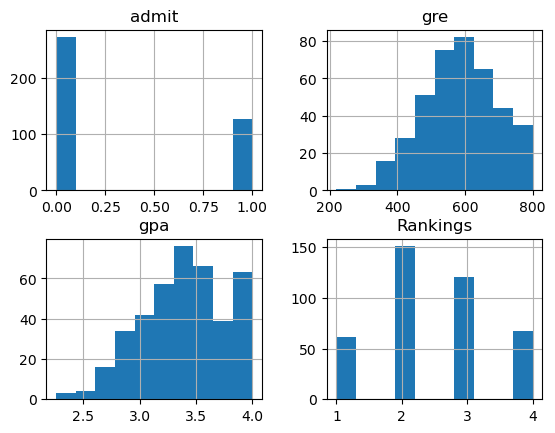

In [8]:
# plot all of the columns
df.hist()
pl.show()

 ### dummy variables
pandas gives you a great deal of control over how categorical variables can be represented. We're going dummify the "prestige" column using get_dummies.

get_dummies creates a new DataFrame with binary indicator variables for each category/option in the column specified. In this case, prestige has four levels: 1, 2, 3 and 4 (1 being most prestigious). When we call get_dummies, we get a dataframe with four columns, each of which describes one of those levels.

In [12]:
# dummify rank
dummy_ranks = pd.get_dummies(df['Rankings'],prefix = 'rankings').astype(int)
dummy_ranks.head()

,rankings_1,rankings_2,rankings_3,rankings_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [13]:
# create a clean data frame for the regression
cols_to_keep = ['admit','gre','gpa']
data = df[cols_to_keep].join(dummy_ranks.loc[:,'rankings_2':])
data.head()

,admit,gre,gpa,rankings_2,rankings_3,rankings_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [ ]:
# manually add the intercept


Once that's done, we merge the new dummy columns with the original dataset and get rid of the prestige column which we no longer need.

Lastly we're going to add a constant term for our logistic regression. The statsmodels function we would use requires intercepts/constants to be specified explicitly.

### Performing the regression
Actually doing the logistic regression is quite simple. Specify the column containing the variable you're trying to predict followed by the columns that the model should use to make the prediction.

In our case we'll be predicting the admit column using gre, gpa, and the prestige dummy variables prestige_2, prestige_3 and prestige_4. We're going to treat prestige_1 as our baseline and exclude it from our fit. This is done to prevent multicollinearity, or the dummy variable trap caused by including a dummy variable for every single category.

In [15]:
train_cols = data.columns[1:]

# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)
logit = sm.Logit(data['admit'],data[train_cols])


# fit the model
result = logit.fit()


Optimization terminated successfully.
         Current function value: 0.589306
         Iterations 5


Since we're doing a logistic regression, we're going to use the statsmodels Logit function. For details on other models available in statsmodels, check out their docs here.

### Interpreting the results
One of my favorite parts about statsmodels is the summary output it gives. If you're coming from R, I think you'll like the output and find it very familiar too.

In [18]:
abc = result.predict([420,2.93,0,0,1])
abc

array([0.15625099])

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.05707
Time:                        10:18:25   Log-Likelihood:                -235.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 9.732e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0014      0.001      1.329      0.184      -0.001       0.003
gpa           -0.1336      0.194     -0.687      0.492      -0.515       0.248
rankings_2    -0.9663      0.300     -3.216      0.001      -1.555      -0.377
rankings_3    -1.5451      0.332     -4.648      0.000      -2.197      -0.894
rankings_4    -1.8776      0.402     -4.676      0.000      -2.665      -1.091
==============================================================================
"""